# Convolutions on Images

In [1]:
%load_ext autoreload 
%autoreload 2

## Install `tfutils`


In [5]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Improving Computer Vision Accuracy using Convolutions

* In the previous notebook, we used simple Dense Neural Network on Fashio MNIST data for image classification, and on the test set we were able to get 0.88 accuracy.
* But Dense networks can't really exploit the local relationships between pixels that are natural in image data. A feature learned in one part of the image must also be useful in other part of the image in the same field of view.
* Convolutional Neural Networks use Parameter sharing to achieve this. A kernel moves around the input feature space, and serves as a feature extractor, lighting up when it sees an interesting pattern. 
* The same kernel moves around (Hence it is called parameter sharing.), calculates the linear weighted sum of input features in the field of view, applies some non-linearity. 
* We can have several such kernels moving around, each extracting a specific feature, which are then concatenated (using on the depth channel).
* The intuition of having more feature extractors i.e. kernels carries over to having N-Heads in transformer neural networks.
* In images, we can tweak the weights of these feature extractors aka kernels to detect edges, vertical lines, horizontal lines etc.
* Only in convolutional neural networks, these kernels are learned from the data.

## Some imports

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tfutils
from tfutils.visualize import plot_learning_curve
from tfutils.image import ImageDataset

import tensorflow as tf
from tensorflow.keras import layers, optimizers, callbacks


## Load Fashion MNIST data

In [3]:
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
# Scale
train_data = train_data/255.0
test_data = test_data/255.0

## Explore the data

In [51]:
cls_labels = np.unique(train_labels)
cls_labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
CLASS_NAMES = dict(zip(cls_labels, ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']))

### `ImageDataset`

In [54]:
imgds = ImageDataset(train_data=(train_images, train_labels), test_data=(test_images, test_labels), classes=CLASS_NAMES)

### Plot the label counts

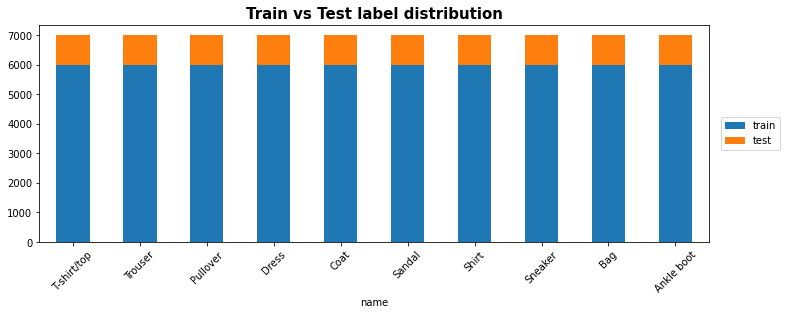

In [56]:
imgds.plot_labelcounts();

### View Random Images

#### train

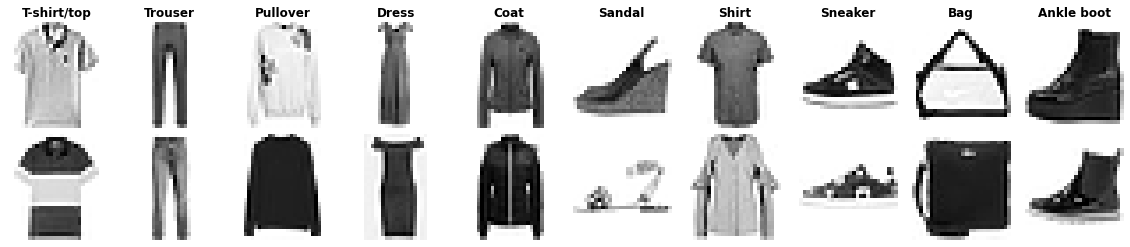

In [57]:
axn = imgds.view_random_images(class_names='all', n_each=2, subset='train')

#### test

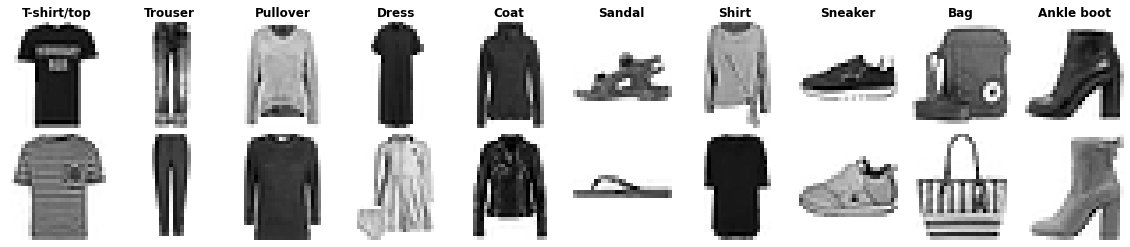

In [58]:
axn = imgds.view_random_images(class_names='all', n_each=2, subset='test')

## Some Global Params

In [9]:
IMAGE_SHAPE = (28, 28)
NUM_CHANNELS = 1
INPUT_SHAPE = (*IMAGE_SHAPE, NUM_CHANNELS)
N_CLASSES = 10

In [4]:
tfmodels = {}

## Lambda layer to reshape the inputs

* Conv2D expects the input shape to be (None, height, width, num_channels)
* Here None is the number of data points, which can be batch size or anything. 
* We can either reshape the input images or use a `Lambda` layer

In [49]:
add_depth_layer = layers.Lambda(lambda t: tf.expand_dims(t, axis=-1))

img = train_images[0, :, :]
print('Original Image Shape:', img.shape)
print('After passing through the layer: ', add_depth_layer(img).shape)


Original Image Shape: (28, 28)
After passing through the layer:  (28, 28, 1)


### Model 1: A simple Conv2D network

In [22]:
model_name = 'simple-conv2d'

In [25]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=IMAGE_SHAPE), 
    add_depth_layer,
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Conv2D(64, 3),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(N_CLASSES, activation=tf.nn.softmax)
], name=model_name)

model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "simple-conv2d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            multiple                  0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)             

In [31]:
history = model.fit(train_images, train_labels, batch_size=32, epochs=20, validation_split=0.1)
tfmodels[model_name] = model

Epoch 1/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0650 - accuracy: 0.9757 - val_loss: 0.0850 - val_accuracy: 0.9673
Epoch 2/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0580 - accuracy: 0.9788 - val_loss: 0.0793 - val_accuracy: 0.9692
Epoch 3/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0518 - accuracy: 0.9804 - val_loss: 0.1166 - val_accuracy: 0.9580
Epoch 4/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0464 - accuracy: 0.9831 - val_loss: 0.1024 - val_accuracy: 0.9642
Epoch 5/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0429 - accuracy: 0.9848 - val_loss: 0.1162 - val_accuracy: 0.9608
Epoch 6/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0424 - accuracy: 0.9841 - val_loss: 0.1193 - val_accuracy: 0.9608
Epoch 7/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0347 - accuracy: 0.9876 - val_loss: 0.1356 - val_accuracy:

### Evaluate

In [32]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.7827 - accuracy: 0.9099


[0.7826728820800781, 0.9099000096321106]

The accuracy is far more than Dense Neural Networks with far less parameters also!

### Learning Curve

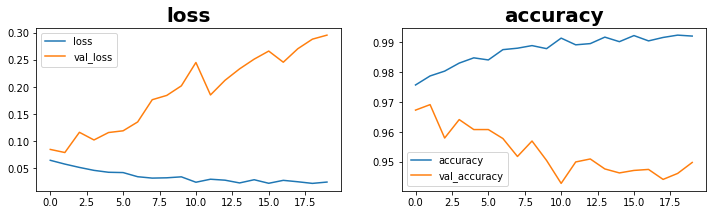

In [33]:
plot_learning_curve(history, extra_metric='accuracy');

The Validation loss is increasing! Which means either the model is too complex. Let us try by adding some dropout layers

### Model 2: simple Conv2D dropout Dense

In [104]:
model_name = 'simple-conv2d-dropout-dense'

In [109]:
model = tf.keras.models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', input_shape=INPUT_SHAPE),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax')
], name=model_name)

model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "simple-conv2d-dropout-dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 128

In [110]:
history = model.fit(np.expand_dims(train_images, axis=-1), train_labels, batch_size=32, epochs=20, validation_split=0.1)
tfmodels[model_name] = model

Epoch 1/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5076 - accuracy: 0.8131 - val_loss: 0.3405 - val_accuracy: 0.8758
Epoch 2/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3559 - accuracy: 0.8691 - val_loss: 0.2916 - val_accuracy: 0.8942
Epoch 3/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3131 - accuracy: 0.8850 - val_loss: 0.2827 - val_accuracy: 0.8945
Epoch 4/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2845 - accuracy: 0.8935 - val_loss: 0.2609 - val_accuracy: 0.8995
Epoch 5/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2663 - accuracy: 0.9000 - val_loss: 0.2482 - val_accuracy: 0.9087
Epoch 6/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2495 - accuracy: 0.9074 - val_loss: 0.2564 - val_accuracy: 0.9022
Epoch 7/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2377 - accuracy: 0.9098 - val_loss: 0.2422 - val_accuracy:

### Evaluate

In [111]:
model.evaluate(np.expand_dims(test_images, axis=-1), test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.2389 - accuracy: 0.9194


[0.2388584166765213, 0.9193999767303467]

Accuracy increased!

### Learning Curve

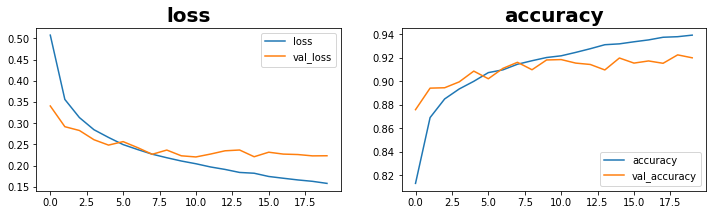

In [112]:
plot_learning_curve(history, extra_metric='accuracy', include_validation=True);

* There still seems to be some overfitting but definitely in the right direction. Maybe we can stop the training early. 
* However it seems our regularization has caused lower accuracy on the training set. Our final aim should be to increase the accuracy on the training set as well, since this is a pretty common dataset and not overly complex

### Model 3: Less Filters with Dropout

In [151]:
model_name = 'simple-conv2d-low-filters-dropout-dense'

In [152]:
model = tf.keras.models.Sequential([
  layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax')
], name=model_name)

model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "simple-conv2d-low-filters-dropout-dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 800)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_36 (Dense)           

In [153]:
history = model.fit(np.expand_dims(train_images, axis=-1), train_labels, batch_size=32, epochs=20, validation_split=0.1)
tfmodels[model_name] = model

Epoch 1/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5581 - accuracy: 0.7950 - val_loss: 0.3889 - val_accuracy: 0.8523
Epoch 2/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4016 - accuracy: 0.8542 - val_loss: 0.3290 - val_accuracy: 0.8763
Epoch 3/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3535 - accuracy: 0.8695 - val_loss: 0.3125 - val_accuracy: 0.8827
Epoch 4/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3257 - accuracy: 0.8794 - val_loss: 0.2868 - val_accuracy: 0.8927
Epoch 5/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3027 - accuracy: 0.8860 - val_loss: 0.2674 - val_accuracy: 0.8995
Epoch 6/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2924 - accuracy: 0.8915 - val_loss: 0.2554 - val_accuracy: 0.9050
Epoch 7/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2771 - accuracy: 0.8958 - val_loss: 0.2550 - val_accuracy:

### Evaluate

In [154]:
model.evaluate(np.expand_dims(test_images, axis=-1), test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.2323 - accuracy: 0.9166


[0.2322918176651001, 0.9165999889373779]

Accuracy increased!

### Learning Curve

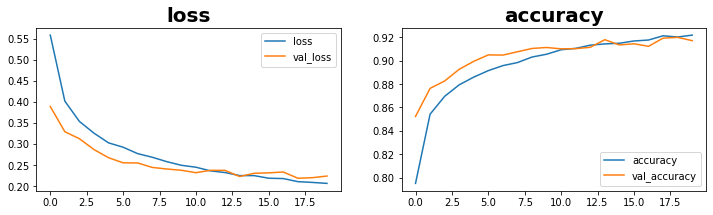

In [155]:
plot_learning_curve(history, extra_metric='accuracy', include_validation=True);

* This is so much better!

### Model 4: Less Filters with Dropout + 2layer Dense

In [162]:
model_name = 'conv2d-low-filters-dropout-dense-2layer'

In [163]:
model = tf.keras.models.Sequential([
  layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(128),
  layers.Dense(32, activation='relu'),
  layers.Dense(10, activation='softmax')
], name=model_name)

model.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "conv2d-low-filters-dropout-dense-2layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 3, 3, 32)          9248      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_21 (Flatten)       

In [164]:
history = model.fit(np.expand_dims(train_images, axis=-1), train_labels, batch_size=32, epochs=10, validation_split=0.1)
tfmodels[model_name] = model

Epoch 1/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.9402 - accuracy: 0.6442 - val_loss: 0.5987 - val_accuracy: 0.7815
Epoch 2/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.7017 - accuracy: 0.7442 - val_loss: 0.5305 - val_accuracy: 0.8045
Epoch 3/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.6254 - accuracy: 0.7748 - val_loss: 0.4630 - val_accuracy: 0.8312
Epoch 4/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5829 - accuracy: 0.7921 - val_loss: 0.4696 - val_accuracy: 0.8330
Epoch 5/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5481 - accuracy: 0.8034 - val_loss: 0.4526 - val_accuracy: 0.8440
Epoch 6/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.5312 - accuracy: 0.8098 - val_loss: 0.4232 - val_accuracy: 0.8512
Epoch 7/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.5137 - accuracy: 0.8157 - val_loss: 0.4095 - val_accuracy:

### Evaluate

In [165]:
model.evaluate(np.expand_dims(test_images, axis=-1), test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.4423 - accuracy: 0.8402


[0.44231313467025757, 0.8402000069618225]

Accuracy increased!

### Learning Curve

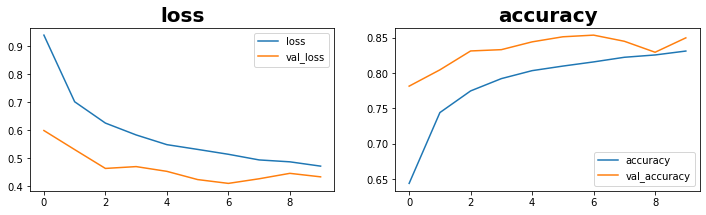

In [166]:
plot_learning_curve(history, extra_metric='accuracy', include_validation=True);

## Compare Performance

In [180]:
from tfutils.evaluate import ClassificationPerformanceComparer

In [181]:
model_predictions = []
for model_name, model in tfmodels.items():
    try:
        pred = model.predict(test_images)
    except ValueError:
        pred = model.predict(np.expand_dims(test_images, axis=-1))
    
    model_predictions.append(pred)



In [182]:
clf_comp = ClassificationPerformanceComparer.from_predictions(model_predictions, data=(test_images, test_labels),
                                                              model_names=list(tfmodels.keys()), class_names=CLASS_NAMES)
clf_comp.calculate_metric_comparison_df()

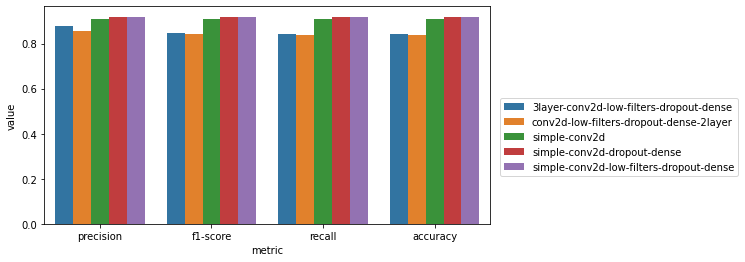

In [183]:
clf_comp.plot_metric_comparison_df()

* Our best model is `simple-conv2d-low-filters-dropout-dense`

# Visualizing the convolutions and Pooling

* Let us visualize the kernels for some of the images
* Kernels light up when they see 

In [114]:
model = tfmodels['simple-conv2d-dropout-dense']

In [115]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)

In [137]:
classes = ['Sandal', 'Sneaker', 'Ankle boot']

imgs = []
labs = []
for cls in classes:
    imgds_subset = imgds.select([cls])[0]
    imgs.append(imgds_subset.train_images)
    labs.append(imgds_subset.train_labels)



imgs = np.vstack(imgs)
labs = np.array(labs)[:, np.newaxis]

In [142]:
preds = activation_model.predict(imgs)

In [144]:
[pred.shape for pred in preds]

[(3, 26, 26, 64),
 (3, 13, 13, 64),
 (3, 11, 11, 64),
 (3, 5, 5, 64),
 (3, 1600),
 (3, 1600),
 (3, 128),
 (3, 10)]

In [139]:
layer_outputs

[<KerasTensor: shape=(None, 26, 26, 64) dtype=float32 (created by layer 'conv2d_35')>,
 <KerasTensor: shape=(None, 13, 13, 64) dtype=float32 (created by layer 'max_pooling2d_34')>,
 <KerasTensor: shape=(None, 11, 11, 64) dtype=float32 (created by layer 'conv2d_36')>,
 <KerasTensor: shape=(None, 5, 5, 64) dtype=float32 (created by layer 'max_pooling2d_35')>,
 <KerasTensor: shape=(None, 1600) dtype=float32 (created by layer 'flatten_17')>,
 <KerasTensor: shape=(None, 1600) dtype=float32 (created by layer 'dropout_8')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_34')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_35')>]

* We would want to visualize the journey of the input image through the convolutions i.e. the first 4 layers

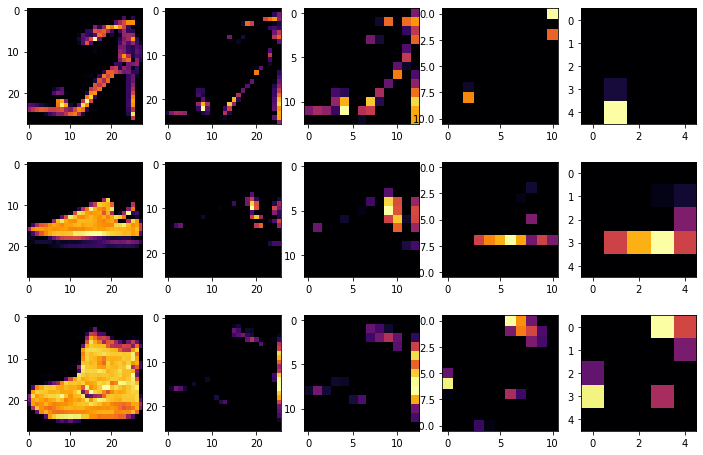

In [149]:
NUM_IMAGES = 3
NUM_LAYERS = 4
CONVOLUTION_NUMBER = 1

fig, axn = plt.subplots(NUM_IMAGES, NUM_LAYERS+1, figsize=(12, 8))

for img_idx in range(NUM_IMAGES):
    for layer_idx in range(NUM_LAYERS+1):
        if layer_idx == 0:
            act = imgs[img_idx]
        else:
            act = preds[layer_idx - 1][img_idx, :, :, CONVOLUTION_NUMBER]

        ax = axn[img_idx, layer_idx]
        ax.imshow(act, cmap='inferno')
